# Supervised Sector Classification

Let's now use the features we constructed and the known sectors to build a supervised classification model. 

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [127]:
agreements_features = pd.read_pickle("classification_features.pkl")

In [128]:
def make_np_vector(x):
    out = np.zeros(len(x))
    for i in range(len(x)):
        out[i] = x[i][1]
    return out

In [129]:
agreements_features.project_description_lsi = agreements_features.project_description_lsi.apply(make_np_vector)

In [130]:
agreements_features.project_name_lsi = agreements_features.project_name_lsi.apply(make_np_vector)

For now, let's just build a model only on the completely labeled data.

In [131]:
labeled_set = agreements_features.dropna(how='any',inplace=False,subset=['project_description_lsi','Project Name','project_name_lsi','sector_id'])
labeled_set = labeled_set.loc[labeled_set.project_name_lsi.apply(len) != 0]
labeled_set = labeled_set.loc[labeled_set.project_description_lsi.apply(len) != 0]

In [132]:
labeled_set.major_sector_name.value_counts()

Public Admin                   122
Transportation                 100
Water/Sanitation/Waste          99
Agriculture                     78
Energy and Extractives          62
Health                          52
Industry and Trade/Services     49
Education                       43
Social Protection               38
Financial Sector                33
Info and Communication           6
Name: major_sector_name, dtype: int64

"Info and Communication" only has 6 data points. We'll just drop it and train on the other 10 classes.

In [133]:
labeled_set = labeled_set.loc[labeled_set.major_sector_name != "Info and Communication"]
labeled_set.major_sector_name.value_counts()

Public Admin                   122
Transportation                 100
Water/Sanitation/Waste          99
Agriculture                     78
Energy and Extractives          62
Health                          52
Industry and Trade/Services     49
Education                       43
Social Protection               38
Financial Sector                33
Name: major_sector_name, dtype: int64

For features, we will use the year, the top 20 topic weights from the LSI topic model for both the project name and the project description, and also the computed similarities to the sector description. Oh, and the year.

In [165]:
desc_features = np.stack(labeled_set.project_description_lsi.to_numpy())[:,:20]
name_features = np.stack(labeled_set.project_name_lsi.to_numpy())[:,:20]
desc_distances = np.stack(labeled_set.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(labeled_set.project_name_similarities_lsi.to_numpy()).squeeze()
X_features = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1) #labeled_set.year.to_numpy().reshape((-1,1)),
#X_features = np.concatenate([desc_features,name_features],axis=1)
y = labeled_set['sector_id'].apply(int).to_numpy().ravel()

In [166]:
#Get sector names
with open("world_bank_sectors.txt") as f:
  sectors = f.read()

sectors_list = sectors.split("\n")

sector_dict = dict()
current_major_sector = ''
for sector in sectors_list:
    if sector == '':
        current_major_sector = ''
        continue
    if current_major_sector == '':
        current_major_sector = sector
        sector_dict[current_major_sector] = []
        continue
    if current_major_sector in sector_dict.keys():
        sector_dict[current_major_sector].append(sector)
sectors = list(sector_dict.keys())
sectors.pop(6) #remove the ignored sector

'Info and Communication'

In [167]:
sectors

['Agriculture',
 'Education',
 'Energy and Extractives',
 'Financial Sector',
 'Health',
 'Industry and Trade/Services',
 'Public Admin',
 'Social Protection',
 'Transportation',
 'Water/Sanitation/Waste']

We'll set aside 25% of the data as a test set.

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features,y,train_size=0.75,stratify=y,random_state=52323)

Let's build some models.

In [169]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


Start with a random forest. Those typically work pretty well. We'll run a grid search over hyperparameters and choose the parameters with the best cross-validation accuracy.

In [170]:
rf_pred = ensemble.RandomForestClassifier(n_estimators=200,max_depth=7,class_weight="balanced",random_state=4252)
rf_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 7, 8],
    #"criterion": ['gini','entropy'],
    "ccp_alpha": [0, 0.001, 0.002, 0.005]
}
rf = GridSearchCV(estimator=rf_pred,param_grid=rf_grid,scoring=make_scorer(accuracy_score),n_jobs=4)

In [171]:
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=7, n_estimators=200,
                                              random_state=4252),
             n_jobs=4,
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.005],
                         'max_depth': [6, 7, 8],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(accuracy_score))

In [172]:
y_train_pred = rf.predict(X_train)
rf_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test,y_test_pred)
rf_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
rf_top2_test_acc = top_k_accuracy_score(y_test,rf.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(rf_train_acc,3))
print("Test Accuracy:", np.round(rf_test_acc,3))
print("Top 2 Test Accuracy:", np.round(rf_top2_test_acc,3))

Train Accuracy: 0.961
Test Accuracy: 0.675
Top 2 Test Accuracy: 0.793


In [173]:
rf.best_params_

{'ccp_alpha': 0, 'max_depth': 8, 'n_estimators': 300}

<Figure size 720x720 with 0 Axes>

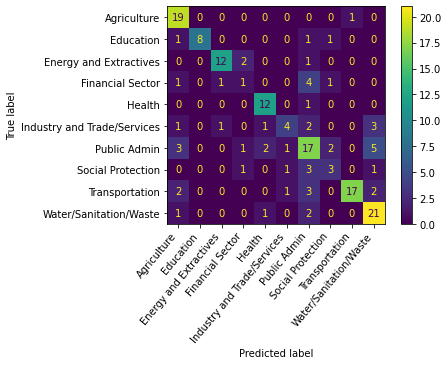

In [174]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

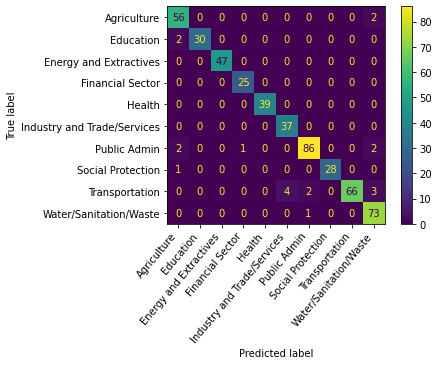

In [175]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Now replace the model with the best version.

In [176]:
rf = rf.best_estimator_

In [177]:
rf.feature_importances_.argsort()

array([ 0, 56,  2, 20, 57, 23, 60, 38, 18, 58, 36, 17, 15, 21, 49,  1, 32,
       16, 22, 14, 34, 45, 30,  3, 35, 47, 59, 33, 51, 43, 61, 48, 53, 27,
       31, 37, 46, 12, 28, 39, 13, 25, 24, 54, 29, 26, 19, 55, 10, 52, 11,
       50,  7, 41, 44, 42, 40,  4,  5,  6,  9,  8])

In [178]:
lin = LogisticRegression(class_weight="balanced",C=1,penalty="elasticnet",l1_ratio=0.8,solver='saga',max_iter=5000, random_state=424)
logistic_grid = {
    "C": [0.1, 0.2, 0.5, 0.75, 1]
}
logistic_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('logistic',GridSearchCV(estimator=lin,param_grid=logistic_grid,scoring=make_scorer(accuracy_score),n_jobs=4))
])
logistic_pipe.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('scale', StandardScaler()),
                ('logistic',
                 GridSearchCV(estimator=LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           l1_ratio=0.8,
                                                           max_iter=5000,
                                                           penalty='elasticnet',
                                                           random_state=424,
                                                           solver='saga'),
                              n_jobs=4,
                              param_grid={'C': [0.1, 0.2, 0.5, 0.75, 1]},
                              scoring=make_scorer(accuracy_score)))])

In [179]:
logistic_pipe['logistic'].best_params_

{'C': 1}

In [180]:
y_train_pred = logistic_pipe.predict(X_train)
log_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = logistic_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test,y_test_pred)
log_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
log_top2_test_acc = top_k_accuracy_score(y_test,logistic_pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(log_train_acc,3))
print("Test Accuracy:", np.round(log_test_acc,3))
print("Top 2 Test Accuracy:", np.round(log_top2_test_acc,3))

Train Accuracy: 0.821
Test Accuracy: 0.645
Top 2 Test Accuracy: 0.787


<Figure size 720x720 with 0 Axes>

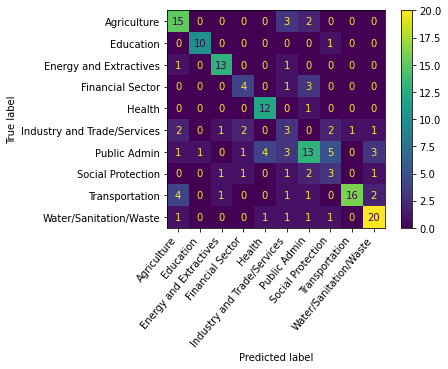

In [181]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(logistic_pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [182]:
logistic_est = logistic_pipe['logistic'].best_estimator_
logistic_pipe.steps.pop(1)
logistic_pipe.steps.append(('logistic',logistic_est))

In [183]:
svm = SVC(max_iter=5000,probability=True,class_weight="balanced",C=2,random_state=1212)
svm_grid = {
    "C": [0.5, 1, 2, 5]
}
pipe = Pipeline([('scale',StandardScaler()),('svm',GridSearchCV(estimator=svm,param_grid=svm_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('svm',
                 GridSearchCV(estimator=SVC(C=2, class_weight='balanced',
                                            max_iter=5000, probability=True,
                                            random_state=1212),
                              n_jobs=4, param_grid={'C': [0.5, 1, 2, 5]},
                              scoring=make_scorer(accuracy_score)))])

In [184]:
y_train_pred = pipe.predict(X_train)
svm_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = pipe.predict(X_test)
svm_test_acc = accuracy_score(y_test,y_test_pred)
svm_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
svm_top2_test_acc = top_k_accuracy_score(y_test,pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(svm_train_acc,3))
print("Test Accuracy:", np.round(svm_test_acc,3))
print("Top 2 Test Accuracy:", np.round(svm_top2_test_acc,3))

Train Accuracy: 0.785
Test Accuracy: 0.645
Top 2 Test Accuracy: 0.787


<Figure size 720x720 with 0 Axes>

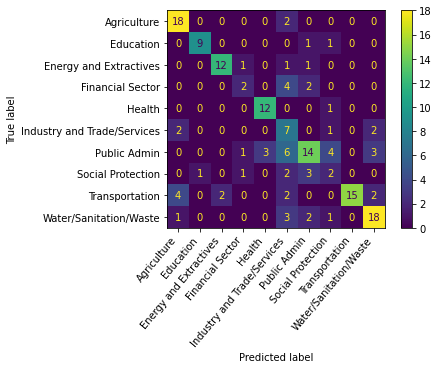

In [185]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

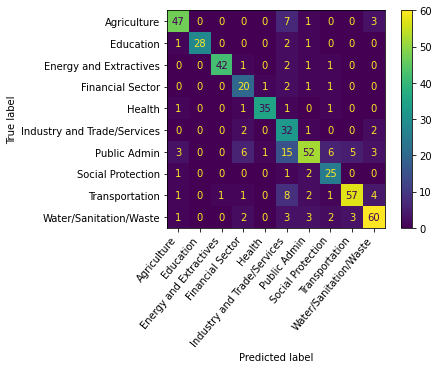

In [186]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [187]:
svm_est = pipe['svm'].best_estimator_
pipe.steps.pop(1)
pipe.steps.append(('svm',svm_est))

In [188]:
mlp_est = MLPClassifier(hidden_layer_sizes=(32,16),max_iter=200,random_state=52234)
mlp_grid = {
    "hidden_layer_sizes": [(32, 16), (32, 32)],
    "max_iter": [200, 300, 400]
}
mlp = Pipeline([('scale', StandardScaler()),('mlp',GridSearchCV(estimator=mlp_est,param_grid=mlp_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
mlp.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scale', StandardScaler()),
                ('mlp',
                 GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(32,
                                                                          16),
                                                      random_state=52234),
                              n_jobs=4,
                              param_grid={'hidden_layer_sizes': [(32, 16),
                                                                 (32, 32)],
                                          'max_iter': [200, 300, 400]},
                              scoring=make_scorer(accuracy_score)))])

In [189]:
y_train_pred = mlp.predict(X_train)
mlp_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = mlp.predict(X_test)
mlp_test_acc = accuracy_score(y_test,y_test_pred)
mlp_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
mlp_top2_test_acc = top_k_accuracy_score(y_test,mlp.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(mlp_train_acc,3))
print("Test Accuracy:", np.round(mlp_test_acc,3))
print("Top 2 Test Accuracy:", np.round(mlp_top2_test_acc,3))

Train Accuracy: 1.0
Test Accuracy: 0.568
Top 2 Test Accuracy: 0.746


In [190]:
mlp['mlp'].best_params_

{'hidden_layer_sizes': (32, 16), 'max_iter': 400}

In [191]:
mlp_est = mlp['mlp'].best_estimator_
mlp.steps.pop(1)
mlp.steps.append(('mlp',mlp_est))

In [192]:
ens = VotingClassifier([
    ('rf',rf),
    ('logistic',logistic_pipe),
    ('svm',pipe),
    ('mlp',mlp)
],voting='soft')#,weights=[0.4,0.2,0.2,0.2])
ens.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(ccp_alpha=0,
                                                     class_weight='balanced',
                                                     max_depth=8,
                                                     n_estimators=300,
                                                     random_state=4252)),
                             ('logistic',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(C=1,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.8,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                      

In [193]:
y_train_pred = ens.predict(X_train)
ens_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = ens.predict(X_test)
ens_test_acc = accuracy_score(y_test,y_test_pred)
ens_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
ens_top2_test_acc = top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(ens_train_acc,3))
print("Test Accuracy:", np.round(ens_test_acc,3))
print("Top 2 Test Accuracy:", np.round(ens_top2_test_acc,3))

Train Accuracy: 0.974
Test Accuracy: 0.651
Top 2 Test Accuracy: 0.793


In [194]:
top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=5)

0.9526627218934911

<Figure size 720x720 with 0 Axes>

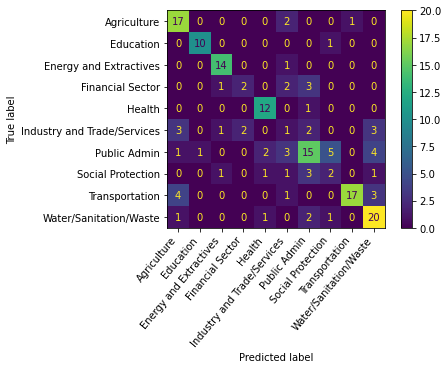

In [195]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(ens,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

This version of the ensemble does worse than the random forest. So let's just use the random forest. We'll fit to the whole dataset before predicting the unlabeled agreements.

In [196]:
rf.fit(X_features,y)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced', max_depth=8,
                       n_estimators=300, random_state=4252)

In [197]:
y_pred = rf.predict(X_features)
accuracy_score(y,y_pred)

0.9127218934911243

<Figure size 720x720 with 0 Axes>

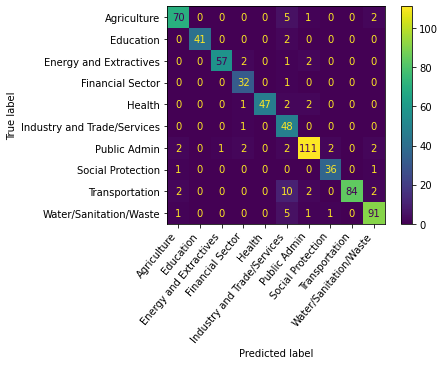

In [198]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_features,y,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [199]:
top_k_accuracy_score(y,rf.predict_proba(X_features),k=2)

0.9615384615384616

In [200]:
good_features = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name'])
good_features = good_features.loc[good_features.project_name_lsi.apply(len) != 0]

In [201]:
good_features.describe()

,Unnamed: 0,year,day,id_x,sector_id,description_topic_predictions,project_name_topic_predictions,description_topic_predictions_doc2vec,project_name_topic_predictions_doc2vec,predictions_doc2vec
count,2833.000000,2833.000000,2833.000000,2.833000e+03,682.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,1598.098129,2003.698553,16.078715,5.387686e+17,5.576246,5.350512,5.368514,4.410519,7.291917,4.502647
std,922.836168,8.918585,8.645879,2.556363e+17,3.441249,2.017310,2.961695,3.177626,1.398595,3.207085
min,0.000000,1990.000000,1.000000,1.002615e+17,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,801.000000,1995.000000,9.000000,3.178015e+17,2.000000,5.000000,3.000000,1.000000,7.000000,1.000000
50%,1601.000000,2004.000000,16.000000,5.285615e+17,7.000000,5.000000,5.000000,5.000000,7.000000,5.000000
75%,2390.000000,2011.000000,23.000000,7.576915e+17,9.000000,6.000000,8.000000,7.000000,8.000000,7.000000
max,3198.000000,2019.000000,31.000000,9.997015e+17,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [203]:
desc_features = np.stack(good_features.project_description_lsi.to_numpy())[:,:20]
name_features = np.stack(good_features.project_name_lsi.to_numpy())[:,:20]
desc_distances = np.stack(good_features.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(good_features.project_name_similarities_lsi.to_numpy()).squeeze()
X_in = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1)

good_features['supervised_predictions'] = rf.predict(X_in)

In [207]:
rf.predict(X_in)

array([ 2,  9, 10, ...,  1,  0,  1])

In [206]:
good_features.supervised_predictions.value_counts()

3     464
7     395
9     347
10    338
2     330
5     275
0     241
1     184
4     136
8     123
Name: supervised_predictions, dtype: int64

In [208]:
good_features['predicted_sector'] = good_features.supervised_predictions.apply(lambda x: sectors[x] if x < 6 else sectors[x-1])

In [209]:
len(good_features)

2833

In [210]:
sector_counts = good_features.predicted_sector.value_counts()

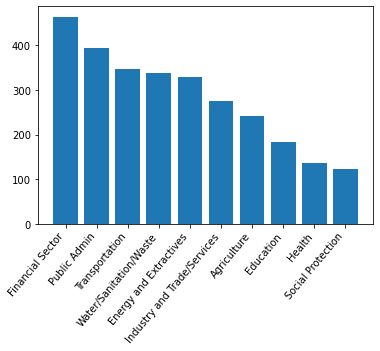

In [211]:
plt.plot(figsize=(8,8))
plt.bar(sector_counts.index, sector_counts.values)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

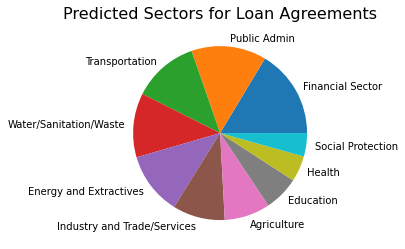

In [213]:
plt.plot(figsize=(12,12))
plt.pie(sector_counts.values,labels=sector_counts.index)
plt.title("Predicted Sectors for Loan Agreements",fontsize=16)
plt.show()

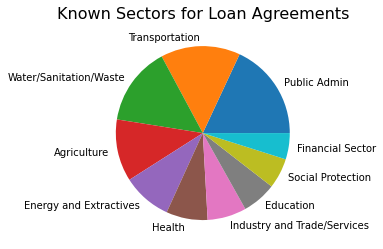

In [214]:
validated_sector_counts = labeled_set.major_sector_name.value_counts()
plt.plot(figsize=(12,12))
plt.pie(validated_sector_counts.values,labels=validated_sector_counts.index)
plt.title("Known Sectors for Loan Agreements",fontsize=16)
plt.show()

In [251]:
good_features.columns

Index(['Unnamed: 0', 'year', 'month', 'day', 'id_x', 'name', 'project_desc',
       'top_common_40', 'Project Name', 'wb_project_id', 'id_y',
       'major_sector_name', 'sector_id', 'project_description_tfidf',
       'project_name_tfidf', 'description_topic_predictions',
       'project_name_topic_predictions',
       'description_topic_predictions_doc2vec',
       'project_name_topic_predictions_doc2vec', 'predictions_doc2vec',
       'project_description_lsi', 'project_name_lsi',
       'description_similarities_lsi', 'project_name_similarities_lsi',
       'supervised_predictions', 'predicted_sector'],
      dtype='object')

In [262]:
good_features.drop(['project_description_tfidf','project_name_tfidf'],axis=1,inplace=True)

In [263]:
good_features.to_pickle('predicted_sectors.pkl')